In [12]:
import cv2
import numpy as np
import numpy as np
import argparse
import cv2
from commonfunctions import *
import math    

from utlis import *
import functools

15
5 3


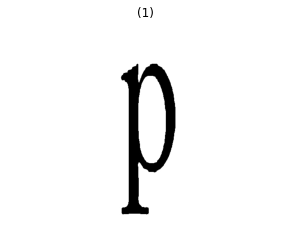

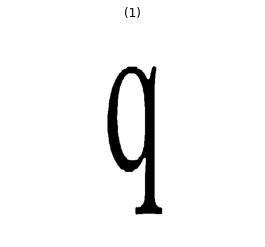

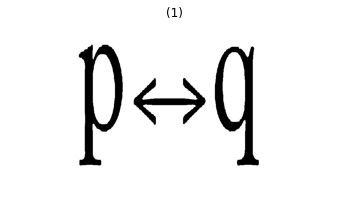

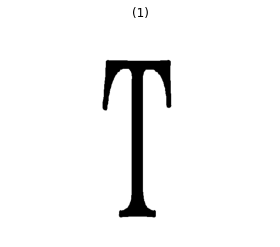

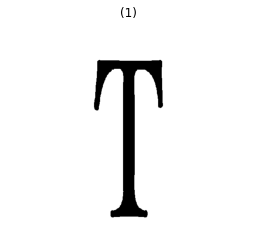

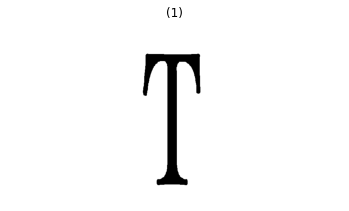

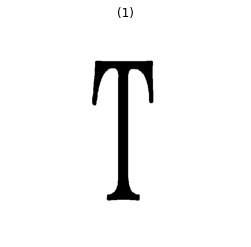

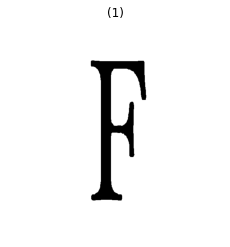

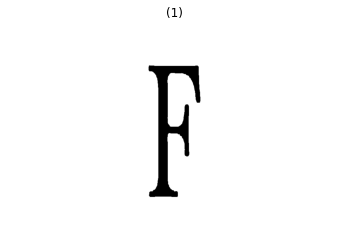

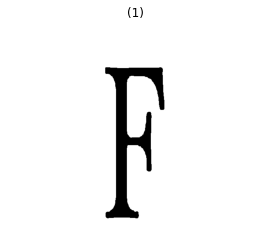

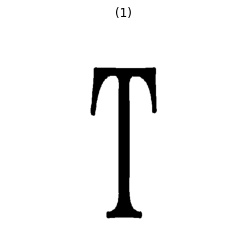

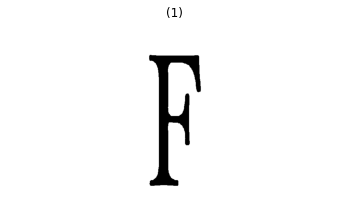

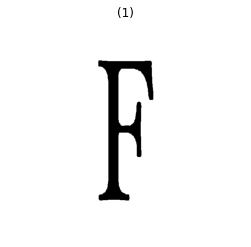

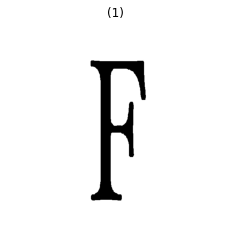

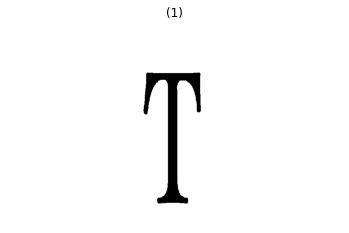

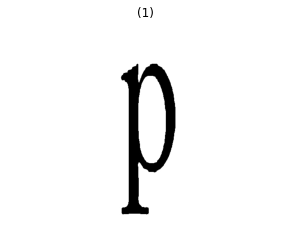

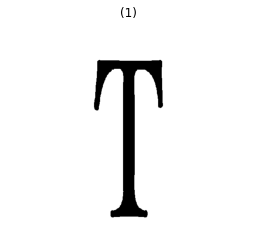

In [13]:
def box_extraction(img_for_box_extraction_path, showTrace):
    img = cv2.imread(img_for_box_extraction_path, 0)
    # img_test = cv2.imread(img_for_box_extraction_path, 1)
    (thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)  # Thresholding the image
    img_bin = 255-img_bin  
    kernel_length = np.array(img).shape[1]//40
    
    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect verticle lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    # cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)

    contours, hierarchy = cv2.findContours(horizontal_lines_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_rows_arr = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if(w<horizontal_lines_img.shape[1]-20 and x!=0 and y!=0 and y< horizontal_lines_img.shape[0]-1):
            num_rows_arr.append(c)
    num_rows = len(num_rows_arr)

    num_rows=3 # comment this line when detect number of rows

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    kernel_two = np.ones((7, 7))
    dilatedImg = cv2.dilate(img_final_bin, kernel_two, iterations=5)
    img_final_bin = cv2.erode(dilatedImg, kernel_two, iterations=1)
    # For Debugging
    # Enable this line to see verticle and horizontal lines in the image which is used to find boxes
    cv2.imwrite("img_final_bin.jpg",img_final_bin)
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    idx = 0
    boundingBox_arr = []

    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        if w < img_final_bin.shape[1]//40 or h < img_final_bin.shape[0]//40 or w > img_final_bin.shape[1]//2 or h > img_final_bin.shape[0]//2:
            continue
        boundingBox_arr.append(cv2.boundingRect(c))

    def contour_sort(br_a, br_b):

        if abs(br_a[1] - br_b[1]) <= 15:
            return br_a[0] - br_b[0]

        return br_a[1] - br_b[1]


    boundingBox_arr = sorted(boundingBox_arr, key=functools.cmp_to_key(contour_sort))

    num_cols = int(len(boundingBox_arr)/num_rows)

    if(showTrace):
        print(len(boundingBox_arr))
        print(num_cols,num_rows)
    
    arr = []
    for c in boundingBox_arr:
        arr.append(img[c[1]:c[1]+c[3], c[0]:c[0]+c[2]])
        idx += 1
        new_img = img[c[1]:c[1]+c[3], c[0]:c[0]+c[2]]
        if(showTrace):
            show_images([new_img])

    arr = np.asarray(arr, dtype="object").reshape((num_cols, num_rows))
    return arr
# box_extraction("table_images/table.jpg", "./Cropped/")
array = box_extraction("../printed.jpg", showTrace=True)
show_images([array[0][0]])
show_images([array[1][1]])
